In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0, '../')
from scipy.optimize import minimize
from scipy.stats import beta
import util.util as util
from util.util import evaluate,SAA_minimise
from scipy.stats import wasserstein_distance
import csv
import pickle
import pandas as pd

The function that is maximised is: <br>
<center> $3x^2 + 6xy^2 - 2x^2y - 7xy$

In [2]:
Y = beta(a = 3,b=3,loc=-1,scale=2)

In [10]:
def wasserstein_constraint(limit,samples,delta):
    distance =np.sum(np.concatenate((limit[0] - samples[limit[0] > samples],
               samples[limit[1] < samples] - limit[1])))
    return  delta-distance/float(samples.shape[0])

In [11]:
def limit_constraint(limit):
    # right hand side must be greater than lefthand side
    return limit[1]-limit[0]

In [12]:
def plot_sample_change(x_star,Sy,new_y,func):
    
    # get a plot of the cost function
    temp_y = np.linspace(np.min(Sy),np.max(Sy),500)
    full_cost = evaluate(x_star,temp_y,func,find_mean=False)
    
    # get cost of samples
    sub_cost = evaluate(x_star,Sy,func,find_mean=False)
    # cost of changed samples
    altered = evaluate(x_star,new_y,func,find_mean=False)
    
    # check which samples have changed
    changed_index = np.isclose(Sy,new_y,atol=1e-2) == False
    
    changed_samples = new_y[changed_index]
    changed_cost = evaluate(x_star,changed_samples,func,find_mean=False)
    original_samples = Sy[changed_index]
    original_cost = sub_cost[changed_index]
    
    # plot the hraph
    plt.figure(figsize=(10,8))
    plt.plot(temp_y,full_cost,label='cost function')
    plt.plot(Sy,sub_cost,'o',label='samples')

    plt.plot(changed_samples,original_cost,'o',label='altered samples')
    for i in range(len(changed_cost)):
        plt.arrow(original_samples[i],
                  original_cost[i],
                  (changed_samples[i]-original_samples[i])*0.7,
                  0,head_width=0.02,length_includes_head=False)
    plt.legend()

In [13]:
def test(limit,x_star,samples,func):
    #new_Sy = np.copy(samples)
    #new_Sy[:np.searchsorted(sort_Sy,limit[0],'right')] = limit[0]
    #new_Sy[np.searchsorted(sort_Sy,limit[1],'left'):] = limit[1]
    
    new_Sy = alter_samples(limit,samples)
    return -evaluate(x_star,new_Sy,func)

In [14]:
def alter_samples(limit,samples):
    new_samples = np.copy(samples)
    new_samples[:np.searchsorted(samples,limit[0],'right')] = limit[0]
    new_samples[np.searchsorted(samples,limit[1],'left'):] = limit[1]
    
    return new_samples

In [15]:
def wasserstein_robustification(samples,x_star,func,delta):

    constraint = [{'type':'ineq','fun':wasserstein_constraint,'args':[samples,delta]},
             {'type':'ineq','fun':limit_constraint}]
    bound = [(-1,1)]*2
    #bound = [(-1,x_star),(x_star,1)]
    limit = [samples[1],samples[-2]]
    res = minimize(test,limit,args=(x_star,samples,func),
                   constraints=constraint,bounds=bound,
                  options={'maxiter': 500,
                          'ftol': 1e-06})
    new_samples = alter_samples(res.x,samples)
    return new_samples

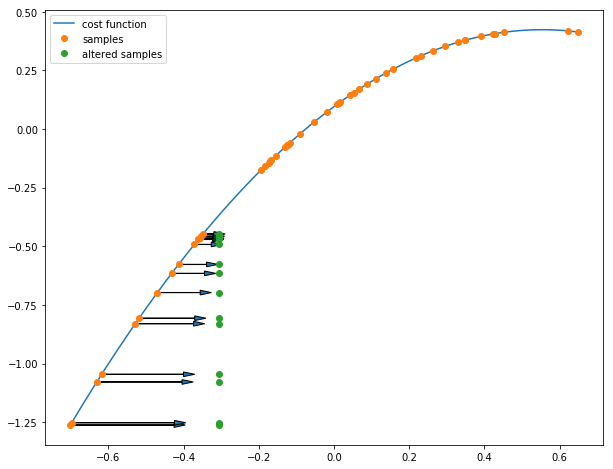

In [9]:
# a test
Sy = Y.rvs(50)
sort_Sy = np.sort(Sy)
x_star = SAA_minimise(sort_Sy,util.f1)
new_sample = wasserstein_robustification(sort_Sy,x_star,util.f1,0.05)
new_xstar= SAA_minimise(new_sample,util.f1)
plot_sample_change(x_star,sort_Sy,new_sample,util.f1)

In [160]:
N = 100
n_iter = 1000
delta = [0.01,0.02,0.05]

In [161]:
%%timeit
with open('results/wasser_convave_N'+ str(N)+'.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['SAA'] + delta)
    n_changed_samples = pd.DataFrame(columns=['SAA'] + delta)
    for k in range(n_iter):
        # samples from distribution
        Sy = Y.rvs(N)
        sort_Sy = np.sort(Sy)
        
        # SAA
        x_star = SAA_minimise(sort_Sy,util.f1)
        wasser_results = []
        temp = [0]
        
        # gpo through each delta
        for d in range(len(delta)):
            new_sample = wasserstein_robustification(sort_Sy,x_star,util.f1,delta[d])
            new_xstar= SAA_minimise(new_sample,util.f1)
            wasser_results += [float(new_xstar)]
            temp += [np.sum(1-np.isclose(new_sample,sort_Sy))]
            
        # write results
        n_changed_samples.loc[k,:] =  temp
        writer.writerow([float(x_star)] + wasser_results)
    n_changed_samples.to_csv('results/wasser_concave_N'+ str(N)+
                             'changed_samples.csv')

1 loop, best of 3: 8.41 s per loop


## Second function
Function is convex in $y$: <br>
<center> $3x^2 + 6xy^2 - 2x^2y - 7xy -5x$

In [3]:
def wasserstein_constraint_convex(variables,bounds,samples,delta):
    """
    in convex functions, the limit is fixed,
    what we try to do is determine the number of samples to move
    to that limit and the fraction of movement
    
    variables[0] and variables[1] is the index, left and right respectively
    variables[2] and variables[3] are weights, elft and right respectively
    """
    new_samples,new_sample_weights,indexes = alter_samples_convex(variables,bounds,samples)
    u_weights = np.ones(samples.shape[0])
    u_weights[0] = 0
    u_weights[-1] = 0
    distance = wasserstein_distance(samples,new_samples,
                                    u_weights=u_weights,
                                    v_weights=new_sample_weights) 
    #distance = [np.sum(np.abs((new_samples-added_samples)))]
    #distance+= [(new_samples[indexes[0]]-bounds[0])*new_sample_weights[indexes[0]]]
    #distance+= [(bounds[1] - new_samples[indexes[1]-1])*new_sample_weights[indexes[1]-1]]
   
    #difference =  np.abs(samples - new_samples)

    return delta-distance

In [27]:
def alter_samples_convex(limit,bounds,samples):
    # returns a set of new samples
    # with weights
    
    new_samples = np.copy(samples)
    left_index = np.searchsorted(samples,limit[0],'left')
    right_index = np.searchsorted(samples,limit[1],'right')
    
    #new_samples[:np.searchsorted(samples,limit[0],'left')] = bounds[0]
    #new_samples[np.searchsorted(samples,limit[1],'right'):] = bounds[1]
    new_samples[:left_index] = bounds[0]
    new_samples[right_index:] = bounds[1]
    
    new_sample_weights = np.ones((new_samples.shape[0]))
    
    
    # the limit it outside samples
    if left_index > 0 and left_index < new_samples.shape[0]:
        new_sample_weights[left_index] = np.maximum(1.0-limit[2],0)
        new_sample_weights[0] = limit[2]
    else:
        new_sample_weights[0] = 0
    # if we're going to move all the samples to the negative side...
    """
    elif left_index == new_samples.shape[0]:
        new_sample_weights[left_index-2] = np.maximum(1.0-limit[2],0)
        new_sample_weights[0] = limit[2]
        new_sample_weights[left_index-1] = 0
    """

    
    
    
    
    if right_index < new_samples.shape[0]:
        new_sample_weights[right_index-1] = np.maximum(1.0-limit[3],0)
        new_sample_weights[-1] = limit[3]
    else:
        new_sample_weights[-1] = 0
    return new_samples, new_sample_weights,[left_index,right_index]

In [28]:
def test_convex(variables,limit,x_star,samples,func):
    # just remember we have samples = [bound_neg, x0,x1,x2,...,xn,bound_pos]
    # assign the weights
    
    new_samples,new_sample_weights,indexs = alter_samples_convex(variables,limit,samples)
    
    return evaluate(x_star,new_samples,func,weights=new_sample_weights)

In [29]:
def wasser_robustification_convex(samples,sample_bounds,x_star,func,delta):
    temp_y = np.linspace(-1,1.5,500)
    full_cost = evaluate(x_star,temp_y,func,find_mean=False)
    minimum = temp_y[np.argmin(full_cost)]
    
    # added limits for computations
    added_samples = np.insert(samples,[0,samples.shape[0]],
                              [sample_bounds[0],sample_bounds[1]])
    
    # constraints and bounds
    constraint = [{'type':'eq','fun':wasserstein_constraint_convex,
                   'args':[sample_bounds,added_samples,delta]},
             {'type':'ineq','fun':limit_constraint}]
    bound = ((sample_bounds[0],minimum),(minimum,sample_bounds[1]),(0.0,1.0),(0.0,1.0))
    
    # initial guess
    # index 0, shape+1 means no movement,
    initial_variable = [samples[1],samples[-1],0.5,0.5]
    
    
    
    res = minimize(test_convex,initial_variable,args=(sample_bounds,x_star,added_samples,func),
                   constraints=constraint,bounds=bound,
                  options={'maxiter': 600,
                          'ftol': 1e-06})
    new_samples = alter_samples_convex(res.x,sample_bounds,added_samples)
    return new_samples,res.x

In [30]:
sample_bounds = [-1,1]
delta = 0.1

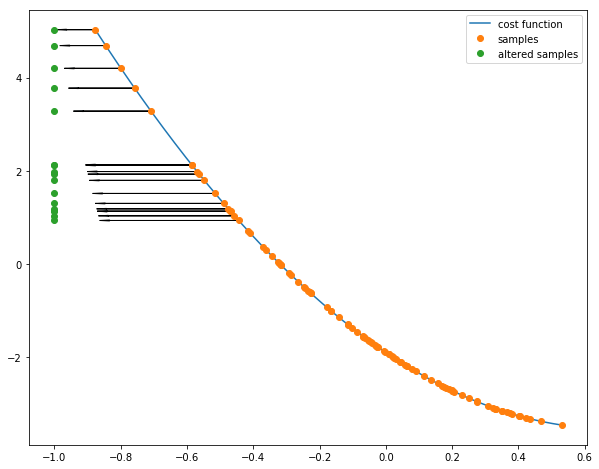

In [31]:
# a test
Sy = Y.rvs(100)
sort_Sy = np.sort(Sy)
x_star = SAA_minimise(sort_Sy,util.f2)
new_sample,_ = wasser_robustification_convex(sort_Sy,sample_bounds,x_star,util.f2,delta)
new_xstar = SAA_minimise(new_sample[0],util.f2,new_sample[1])
plot_sample_change(x_star,sort_Sy,new_sample[0][1:-1],util.f2)

In [32]:
N_samples = [10,20,50,100]
n_iter = 1000
delta = [0.02,0.05,0.7]

In [ ]:
%time
for N in N_samples:
    with open('results/wasser_convex_N'+ str(N)+'.csv', 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['SAA'] + delta)
        n_changed_samples = pd.DataFrame(columns=['SAA'] + delta)
        for k in range(n_iter):
            # samples from distribution
            Sy = Y.rvs(N)
            sort_Sy = np.sort(Sy)

            x_star = SAA_minimise(sort_Sy,util.f2)
            wasser_results = [float(x_star)]
            temp = [0]
            for d in range(len(delta)):
                new_sample,_ = wasser_robustification_convex(sort_Sy,sample_bounds,
                                                             x_star,util.f2,delta[d])
                new_xstar = SAA_minimise(new_sample[0],util.f2,new_sample[1])

                # store rersults
                wasser_results += [float(new_xstar)]
                temp += [np.sum(1-np.isclose(new_sample[0][1:-1],sort_Sy))]

            # write results
            n_changed_samples.loc[k,:] =  temp

            writer.writerow(wasser_results)
            n_changed_samples.to_csv('results/wasser_convex_N'+ str(N)+
                                 'changed_samples.csv')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


## Results

### function 1

In [24]:
N = [10,20,50,100]
delta = [0.01,0.02,0.05]

In [18]:
data = []
for ele in N:
    data.append(pd.read_csv('results/wasser_convave_N'+str(ele)+'.csv').mean())
data = np.array(data)

We show a plot of the mean and std of results of robustification vs SAA

Text(0.5,1,'Deviation from true value concave function')

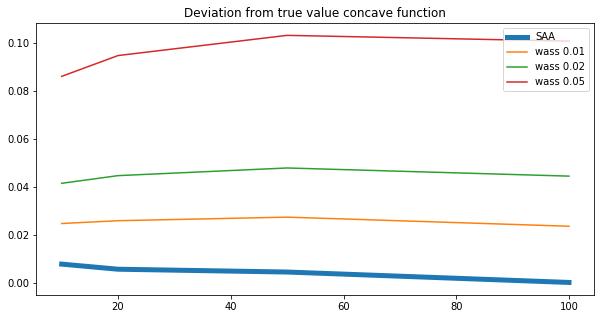

In [26]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,data[:,0]+1.0/7,label='SSA approximation',lw=5.0,ls='-')
lineObjects += plt.plot(N,data[:,1:]+1.0/7)
strings = ['wass '+ str(ele) for ele in delta]
plt.legend(lineObjects,tuple(['SAA'] + strings + ['True value']))
plt.title("Deviation from true value concave function")

In [29]:
data = []
for ele in N:
    data.append(pd.read_csv('results/wasser_convave_N'+str(ele)+'.csv').std())
data = np.array(data)

Text(0.5,1,'Standard Deviation')

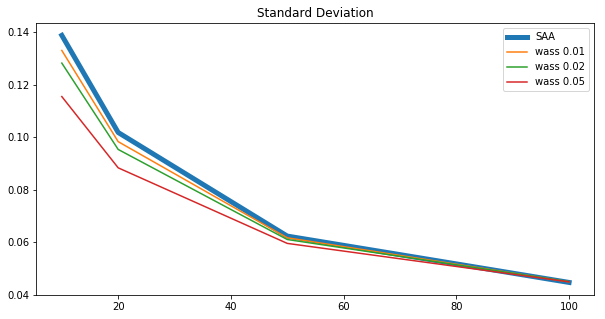

In [32]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,data[:,0],label='SSA approximation',lw=5.0,ls='-')
lineObjects += plt.plot(N,data[:,1:])

strings = ['wass '+ str(ele) for ele in delta]
plt.legend(lineObjects,tuple(['SAA'] + strings + ['True value']))
plt.title('Standard Deviation')

We plot the number of data points changed due to robustification for each sample (N=10,20,50,100) group

In [36]:
## distribution of the number of samples changed during robustification
data = []
for ele in N:
    data.append(pd.read_csv('results/wasser_concave_N'+str(ele)+'changed_samples.csv',index_col=0))

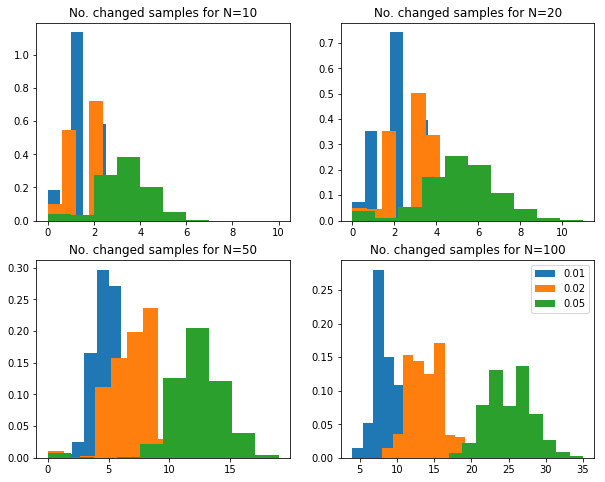

In [59]:
plt.figure(figsize=(10,8))
for i in range(len(N)):
    plt.subplot(2,2,i+1)
    for ele in delta:
        plt.hist(data[i][str(ele)],normed=True,label=str(ele))
    plt.title("No. changed samples for N="+str(N[i]))

plt.legend()